In [1]:
import recommender as r
import spark_data as p

import numpy as np
from pyspark import SparkContext
from pyspark.sql import SQLContext
from pyspark.sql.functions import col
from pyspark.sql import functions as F
from pyspark.sql import types

import importlib

In [2]:
importlib.reload(r)
importlib.reload(p)

<module 'spark_data' from '/home/r/data_inc/plan-your-meetup/spark_data.py'>

In [3]:
sc = SparkContext("local[*]", "temp")
sqlc = SQLContext(sc)

In [4]:
df_group = r.make_DF(sc, 'group').cache()
df_event = r.make_DF(sc, 'event').cache()
df_rsvp = r.make_DF(sc, 'rsvp').cache()

In [6]:
event_select = ['event_id', 'yes_rsvp', 'group_id', 'event_time_stamp', 'event_create_stamp']
group_select = ['group_id', 'city', 'topic'] 
df_event_info = df_event.select(event_select) \
                        .join(df_group.select(group_select), 'group_id') \
                        .cache() 

In [9]:
def get_median(list_nums):
    try:
        median = np.nanmedian(list_nums)
        return int(round(median))
    except Exception:
        return None
udf_median = F.udf(get_median, types.IntegerType())       

1. get the median of rsvp timestamp for each event

In [12]:
yes_select = ['rsvp_create_stamp', 'event_id']
df_rsvp_median = df_rsvp.filter(col('response') == 'yes') \
       .select(col('rsvp_create_stamp'), col('event_id')) \
       .groupby('event_id').agg(F.collect_list('rsvp_create_stamp').alias('timestamps')) \
       .withColumn('rsvp_median', udf_median('timestamps')).cache()

In [16]:
df_rsvp_event_info = df_rsvp_median.select(col('event_id'), col('rsvp_median')) \
                        .join(df_event_info, 'event_id').cache()

2. get the raw time difference between event time and median rsvp time for each event

3. get the noralized time different 

In [81]:
selected = ['event_id', 'yes_rsvp', 'city', 'topic',
            'rsvp_median', 'event_time_stamp', 'event_create_stamp']
df_rsvp_before =  df_rsvp_event_info.select(selected) \
        .withColumn('rsvp_before', (col('event_time_stamp') - col('rsvp_median')) / 3600) \
        .withColumn('event_create',(col('event_time_stamp') - col('event_create_stamp')) / 3600) \
        .withColumn('rsvp_normalized', col('rsvp_before') / col('event_create')) \
        .toPandas()

median of rsvp time

4.plot explorative statistics

In [91]:
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
import dataset as d

In [94]:
topics = d.load_topics()
df = df_rsvp_before

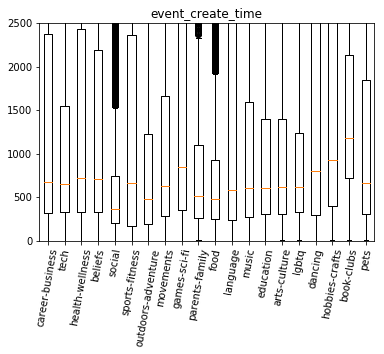

In [110]:
xs = []
for topic in topics:
    xs.append(df.loc[(df.yes_rsvp >= 10) &(df.topic == topic), 'event_create'].values)
    
plt.boxplot(xs)
plt.ylim(0, 2500)
plt.xticks(np.arange(1,21), topics, rotation=80)
plt.title('event_create_time')
plt.show()

normalized rsvp time

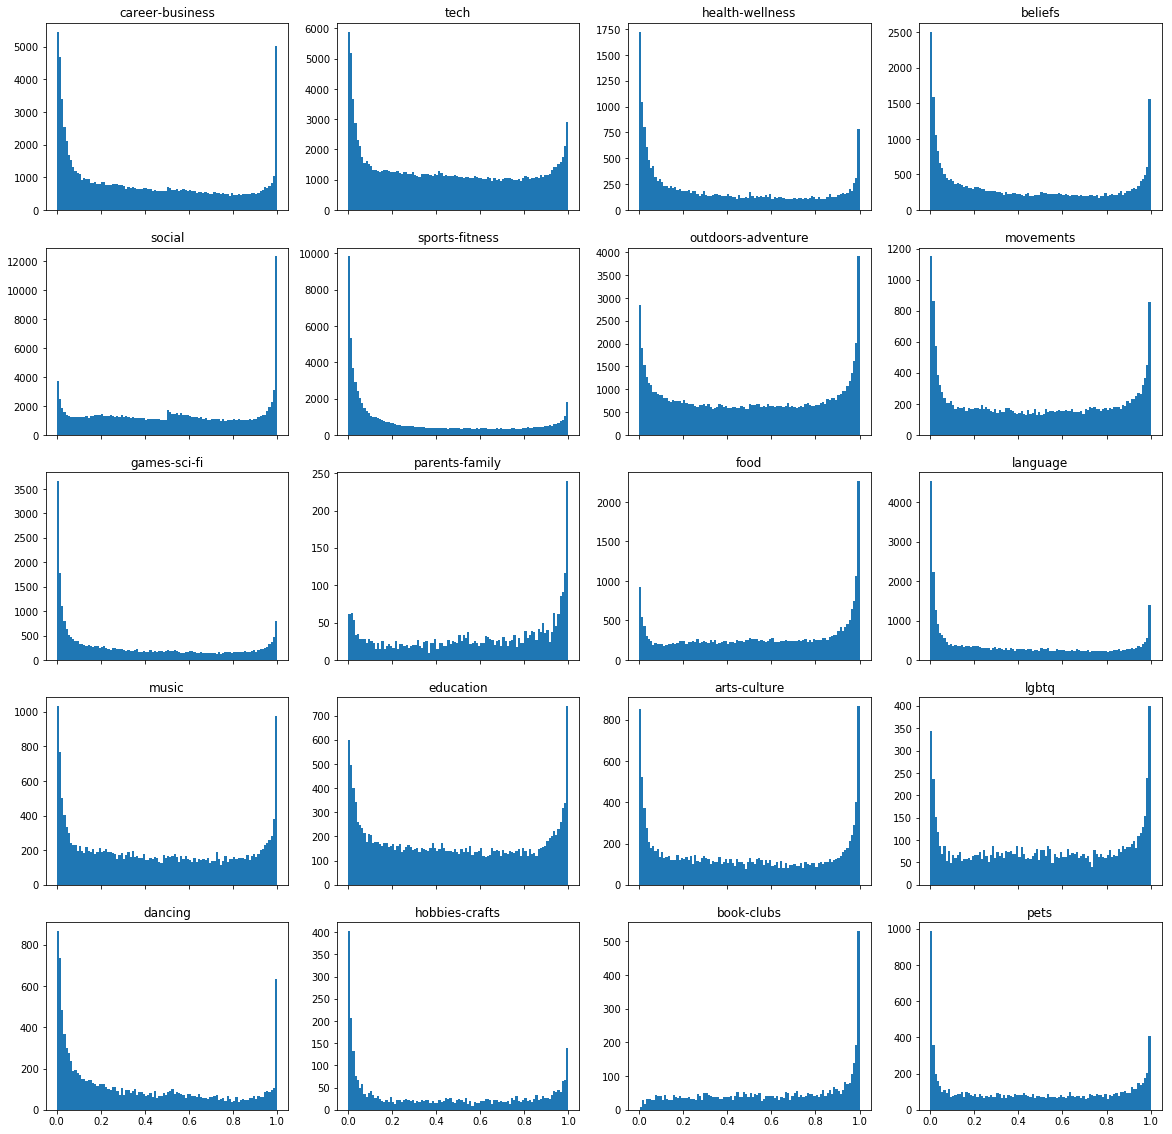

In [130]:
fig, axes = plt.subplots(nrows=5, ncols=4, figsize=(20,20), sharex=True)
for i, ax in enumerate(axes.flatten()):
    xs = df.loc[(df.yes_rsvp >= 10) &(df.topic == topics[i]), 'rsvp_normalized'].values
    xs = [x for x in xs if (0< x < 1)]
    ax.hist(xs, bins=100)
    ax.set_title(topics[i])

raw rsvp time

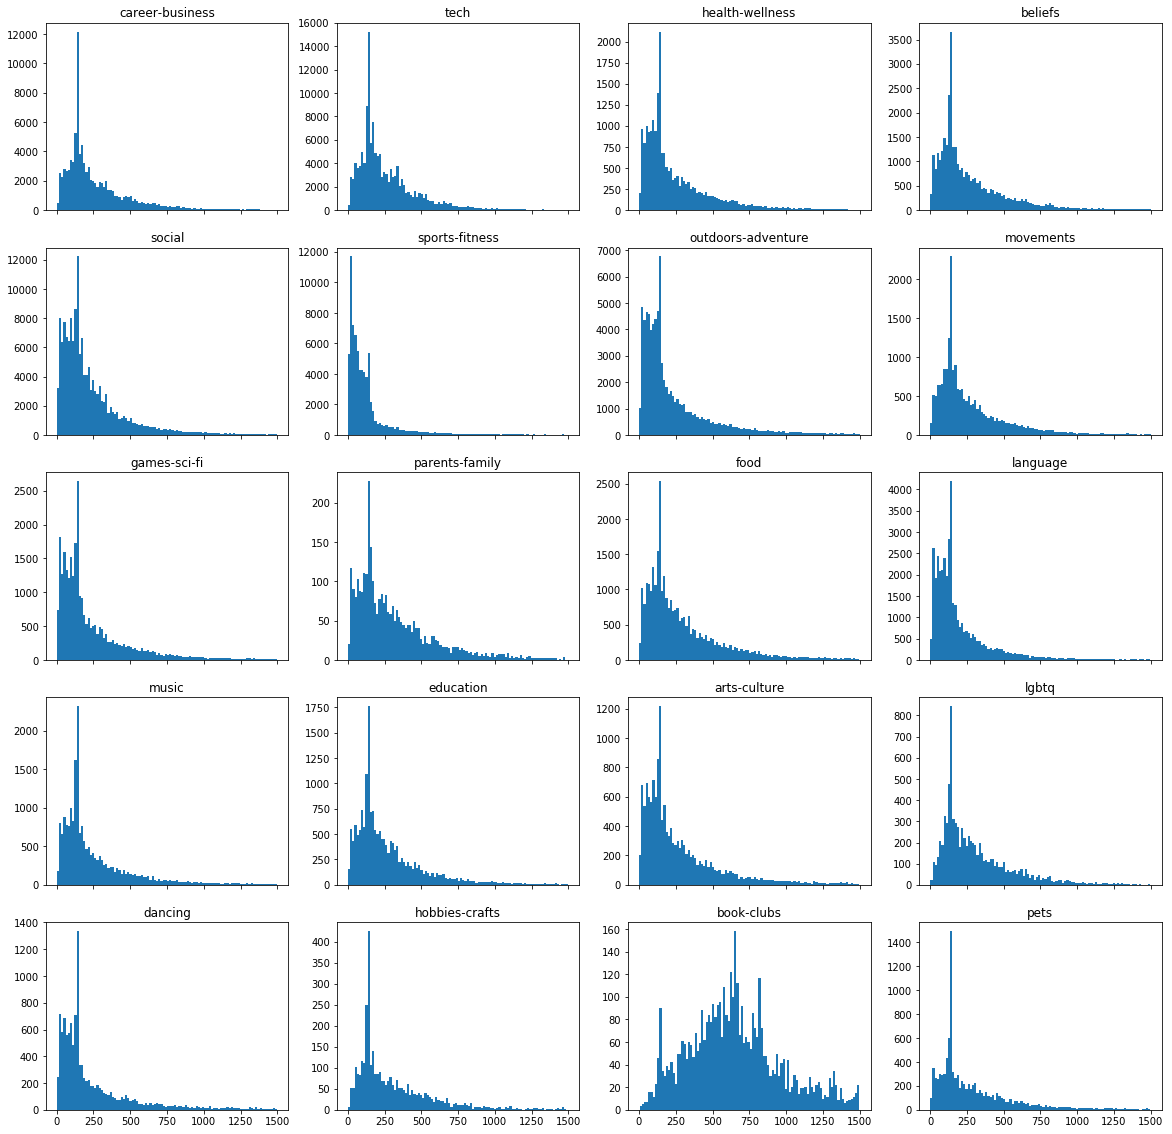

In [133]:
fig, axes = plt.subplots(nrows=5, ncols=4, figsize=(20,20), sharex=True)
for i, ax in enumerate(axes.flatten()):
    xs = df.loc[(df.yes_rsvp >= 10) &(df.topic == topics[i]), 'rsvp_before'].values
    xs = [x for x in xs if (0< x < 2000)]
    ax.hist(xs, bins=100)
    ax.set_title(topics[i])

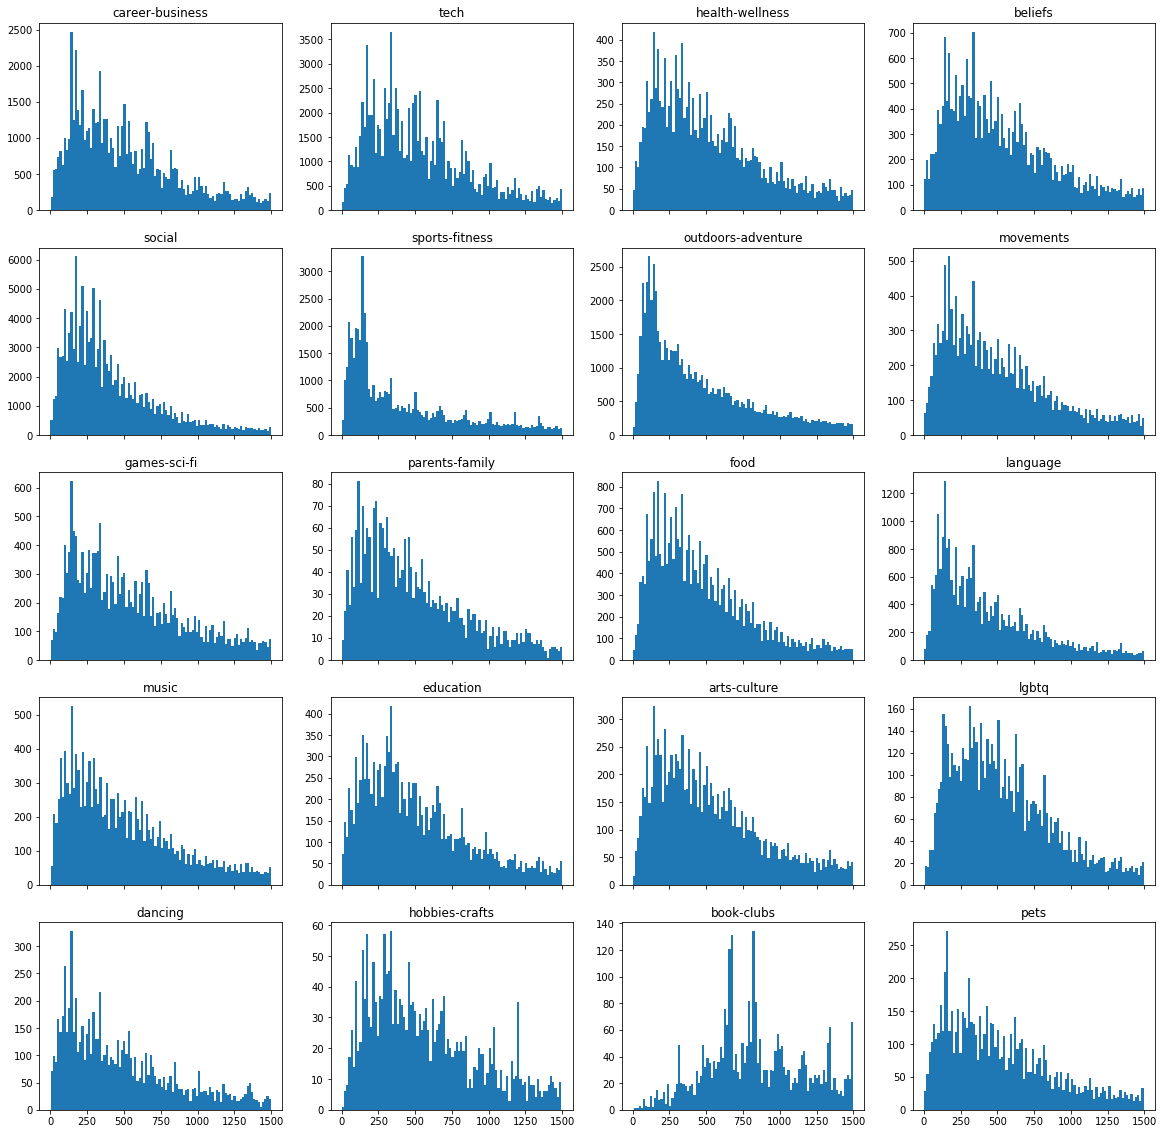

In [134]:
fig, axes = plt.subplots(nrows=5, ncols=4, figsize=(20,20), sharex=True)
for i, ax in enumerate(axes.flatten()):
    xs = df.loc[(df.yes_rsvp >= 10) &(df.topic == topics[i]), 'event_create'].values
    xs = [x for x in xs if (0< x < 1500)]
    ax.hist(xs, bins=100)
    ax.set_title(topics[i])

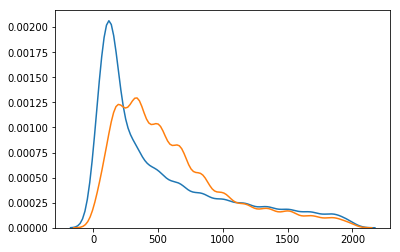

In [146]:
x1s = df.loc[(df.yes_rsvp >= 10) &(df.topic == 'sports-fitness'), 'event_create'].values
x2s = df.loc[(df.yes_rsvp >= 10) &(df.topic == 'tech'), 'event_create'].values
sns.kdeplot([x for x in x1s if x < 2000])
sns.kdeplot([x for x in x2s if x < 2000], bw = 50)
# plot.axes.set_xlim([0,1500])

/home/r/.local/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


(0, 1500)

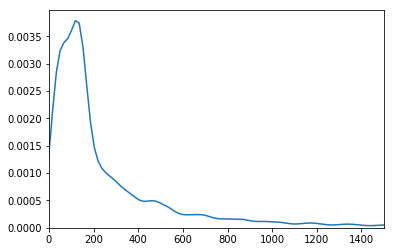

In [60]:
xs = df.loc[(df.yes_rsvp >= 10) &(df.topic == 'dancing'), 'event_create'].values
plot = sns.kdeplot([x for x in xs if x < 2000])
plot.axes.set_xlim([0,1500])